In [149]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import os

In [150]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Make bed file index file

In [151]:
def make_index_file(directory,out_file):
    peaks=[x for x in os.listdir(directory) if ".bed" in x]
    with open(out_file,"w") as out_file:
        for x in peaks:
            out_file.write(directory+"/"+x+"\n")

## Get TF GREGOR output files

In [156]:
def get_gregor(directory,exp):
    
    compiled=pd.DataFrame()

    for x in exp:
        df=pd.read_csv(directory+"/"+x+"/StatisticSummaryFile.txt",delimiter="\t")
        df["type"]=x
        compiled=compiled.append(df)
    
    compiled["ratio"]=(compiled["InBed_Index_SNP"]-compiled["ExpectNum_of_InBed_SNP"])/(compiled["ExpectNum_of_InBed_SNP"])
    return(compiled)
    

In [163]:
df=get_gregor("/cellar/users/mpagadal/Programs/GREGOR/histone",["nonhla_sig"])

In [164]:
df["TF"]=df["Bed_File"].str.split(".").str[1]
df["cell"]=df["Bed_File"].str.split(".H").str[0]

### Get mean and standard error

In [168]:
df_mean=df[["TF","ratio"]].groupby("TF").mean()
df_std=df[["TF","ratio"]].groupby("TF").std()
df_counts=df["TF"].value_counts().reset_index()
df_counts=df_counts.set_index("index")

In [170]:
df=pd.merge(df_mean, df_std, left_index=True, right_index=True)
df=pd.merge(df, df_counts, left_index=True, right_index=True)
df.columns=["mean","std","num"]

In [171]:
df["se"]=df["std"]/np.sqrt(df["num"])

In [172]:
df=df.sort_values(by="mean",ascending=False)

In [173]:
df.index=df.index.str.split("-").str[0]

In [174]:
df.head()

,mean,std,num,se
H3K36me3,0.903164,0.278669,34,0.047791
H3K4me3,0.689922,0.163808,49,0.023401
H3K27ac,0.601989,0.289965,29,0.053845
H3K9ac,0.565153,0.209427,15,0.054074
H2AFZ,0.470296,0.138827,9,0.046276


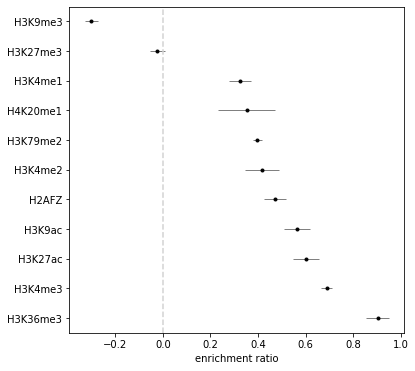

In [175]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.errorbar(df["mean"].tolist(),df.index.tolist(), xerr=df["se"].tolist(), fmt='.', color='black',
             ecolor='gray', elinewidth=1);
plt.axvline(0,linestyle="--",color="lightgray")
plt.xlabel("enrichment ratio")
plt.savefig("histone.pdf")

### get cell types with at least 6 experiments

In [120]:
cell_counts=compiled["cell"].value_counts().reset_index()
cell_lst=cell_counts[cell_counts["cell"]>6]["index"].tolist()

In [121]:
compiled_filt=compiled[compiled["cell"].isin(cell_lst)]

In [122]:
df_plot_cell=compiled_filt.pivot(index="TF",columns="cell",values="ratio")

In [123]:
df_plot_cell=df_plot_cell.loc[df.index.tolist()]

In [124]:
df_plot_cell=df_plot_cell.fillna(0)

In [125]:
df_plot_cell=df_plot_cell.stack().reset_index()

In [126]:
df_plot_cell["TF"].value_counts()

H3K9ac      14
H3K4me2     14
H3K4me3     14
H3K27ac     14
H3K4me1     14
H3K9me3     14
H3K27me3    14
H2AFZ       14
H4K20me1    14
H3K36me3    14
H3K79me2    14
Name: TF, dtype: int64

In [127]:
df_plot_cell["color"]=np.where(df_plot_cell[0]>=0,1,-1)

In [128]:
df_plot_cell

,TF,cell,0,color
0,H3K36me3,Bcell,1.020498,1
1,H3K36me3,CD14-positivemonocyte,1.174394,1
2,H3K36me3,CD8-positivealpha-betaTcell,1.099280,1
3,H3K36me3,endothelialcellofumbilicalvein,0.834134,1
4,H3K36me3,fibroblastofdermis,0.000000,1
...,...,...,...,...
149,H3K9me3,mammaryepithelialcell,-0.379267,-1
150,H3K9me3,osteoblast,-0.411557,-1
151,H3K9me3,peripheralbloodmononuclearcell,-0.098730,-1
152,H3K9me3,skeletalmusclemyoblast,-0.422136,-1


In [147]:
n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(220, 20, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

-1


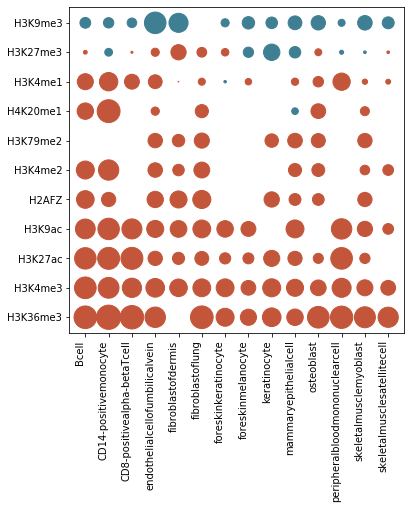

In [148]:
def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation
    
    print(color_min)
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color.apply(value_to_color)# Vector of square sizes, proportional to size parameter
        # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.xticks(rotation=90)
    
heatmap(
    x=df_plot_cell['cell'],
    y=df_plot_cell["TF"],
    size=df_plot_cell[0].abs(),
    color=df_plot_cell["color"]
)
plt.savefig("histone.epi.pdf")

In [135]:
df_plot_cell["color"]

0      1
1      1
2      1
3      1
4      1
      ..
149   -1
150   -1
151   -1
152   -1
153   -1
Name: color, Length: 154, dtype: int64